In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt

Using TensorFlow backend


In [2]:
# load train, test, validation splits
saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DrowsinessDetectionOnCombinedDataset/saved_data/train_test_val_splits_preprocessed_combined_dataset/'

X_train = np.load(saved_dir + 'X_train.npy')

X_val = np.load(saved_dir + 'X_val.npy')

y_train = np.load(saved_dir + 'y_train.npy')

y_val = np.load(saved_dir + 'y_val.npy')

In [3]:
def build_model(hp):
    # pretrained model - MobileNetV2
    # all should be numpy arrays or tensors before giving it to MobileNetV2
    """
    tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,                 # Shape of input data (MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.) 
    alpha=1.0,                        # Width multiplier for controlling network width (default is 1.0)
    include_top=True,                 # Include fully connected top layers (default is True)
    weights='imagenet',               # Weight initialization ('imagenet' for pre-trained weights, None for random initialization)
    input_tensor=None,                # Optional input tensor (default is None)
    pooling=None,                     # Pooling type for the last layer ('avg', 'max', or None; default is None)
    classes=1000,                     # Number of output classes (default is 1000 for ImageNet)
    classifier_activation='softmax',   # Activation function for output layer (default is 'softmax')
    **kwargs                          # Additional keyword arguments
    )
    """
    
    # we dont have to set anything and keep its default values
    MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
    
    # Make all layers in the model non-trainable - freeze
    for layer in MobileNetV2_model.layers:
        layer.trainable = False
        
    base_input = MobileNetV2_model.layers[0].input
    base_output = MobileNetV2_model.layers[-3].output
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_output)
    
    # Hyperparameter: Include Dense Layer (True or False)
    include_dense = hp.Boolean('include_dense')

    if include_dense:
        # Hyperparameter: Number of neurons in the dense layer
        num_neurons = hp.Int('num_neurons', min_value=32, max_value=512, step=32)
        dense_layer = tf.keras.layers.Dense(num_neurons, activation='relu')(global_average_layer)
        # Hyperparameter: Dropout rate
        '''
        Dropout is a regularization technique that helps prevent overfitting by randomly 
        setting a fraction of the input units to 0 during training.
        '''
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        dropout_layer = tf.keras.layers.Dropout(dropout_rate)(dense_layer)
        final_output = tf.keras.layers.Dense(1)(dropout_layer)
    else:
        final_output = tf.keras.layers.Dense(1)(global_average_layer)
        
    final_output = tf.keras.layers.Activation("sigmoid")(final_output)
    
    drowsiness_detection_model = tf.keras.Model(inputs=base_input, outputs=final_output)
    
    # Hyperparameter: Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    drowsiness_detection_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return drowsiness_detection_model

In [4]:
# Initialize the Keras Tuner RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # The metric to optimize
    max_trials=10,             # Number of hyperparameter combinations to try
    directory='tuner_dir',      # Directory for saving results
    project_name='drowsiness_detection_tuner'  # Name of the project
)

In [5]:
# Hyperparameter: Batch size
batch_size = 32 # hp.Int('batch_size', min_value=16, max_value=128, step=16)

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)
    
# Start the hyperparameter search using your training data with early stopping
tuner.search(X_train, y_train,
             epochs=100, 
             validation_data=(X_val, y_val), 
             batch_size=batch_size,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Trial 10 Complete [03h 04m 41s]
val_accuracy: 0.9693187475204468

Best val_accuracy So Far: 0.9694488048553467
Total elapsed time: 2d 15h 10m 58s


In [6]:
tuner.results_summary()

Results summary
Results in tuner_dir\drowsiness_detection_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
include_dense: True
learning_rate: 0.001
num_neurons: 224
dropout_rate: 0.0
Score: 0.9694488048553467

Trial 09 summary
Hyperparameters:
include_dense: True
learning_rate: 0.001
num_neurons: 416
dropout_rate: 0.4
Score: 0.9693187475204468

Trial 08 summary
Hyperparameters:
include_dense: True
learning_rate: 0.0001
num_neurons: 288
dropout_rate: 0.2
Score: 0.9680187106132507

Trial 05 summary
Hyperparameters:
include_dense: True
learning_rate: 0.0001
num_neurons: 192
dropout_rate: 0.0
Score: 0.9677587151527405

Trial 02 summary
Hyperparameters:
include_dense: True
learning_rate: 0.001
num_neurons: 32
dropout_rate: 0.0
Score: 0.9673687219619751

Trial 00 summary
Hyperparameters:
include_dense: False
learning_rate: 0.0001
Score: 0.9619084596633911

Trial 06 summary
Hyperparameters:
include_dense: False
learning_rate: 0.00

When include_dense is set to False, the values for num_neurons and dropout_rate are still generated as hyperparameters, but they won't be used in creating the dense layer or dropout layer in the model. In this case, those hyperparameters are effectively placeholders, and their values are not used because you've excluded the dense layer from the model.

In [12]:
tuner.get_best_hyperparameters()[0].values

{'include_dense': True,
 'learning_rate': 0.001,
 'num_neurons': 224,
 'dropout_rate': 0.0}

In [14]:
# 1st best model
best_model = tuner.get_best_models(num_models=1)[0]

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)
    
# Train the model with the best hyperparameters
history_of_model = best_model.fit(X_train, 
                                   
               y_train,
               epochs=100, 
               validation_data=(X_val, y_val), 
               batch_size=32,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/100
1122/1122 [==============================] - 1268s 1s/step - loss: 0.0442 - accuracy: 0.9831 - val_loss: 0.0998 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 2/100
1122/1122 [==============================] - 1200s 1s/step - loss: 0.0430 - accuracy: 0.9834 - val_loss: 0.0946 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 3/100
1122/1122 [==============================] - 1196s 1s/step - loss: 0.0395 - accuracy: 0.9845 - val_loss: 0.0997 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 4/100
1122/1122 [==============================] - 1039s 926ms/step - loss: 0.0365 - accuracy: 0.9858 - val_loss: 0.1009 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 5/100
1122/1122 [==============================] - 672s 599ms/step - loss: 0.0333 - accuracy: 0.9861 - val_loss: 0.0922 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 6/100
1122/1122 [==============================] - 682s 608ms/step - loss: 0.0322 - accuracy: 0.9875 - val_loss: 0.1145 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 7/100
1122/1122 [==========

there is no improvement in the validation loss from the 6th epoch to the 10th epoch. After the 5th epoch (6th, 7th, 8th, 9th, and 10th), the validation loss does not decrease but starts to increase. Since the patience is set to 5, the training stops at the 10th epoch when it detects that the validation loss has not improved for 5 consecutive epochs, as required by the patience setting.

In [15]:
# Save the model architecture and weights
save_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DrowsinessDetectionOnCombinedDataset/saved_data/models/'

best_model.save(save_dir + 'drowsiness_detection_model_hpt_best_model.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
import pickle

# Save the history object to a file
with open(save_dir + 'drowsiness_detection_hpt_best_model_history.pkl', 'wb') as file:
    pickle.dump(history_of_model.history, file)

In [17]:
training_loss = history_of_model.history['loss']
validation_loss = history_of_model.history['val_loss']

training_accuracy = history_of_model.history['accuracy']
validation_accuracy = history_of_model.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

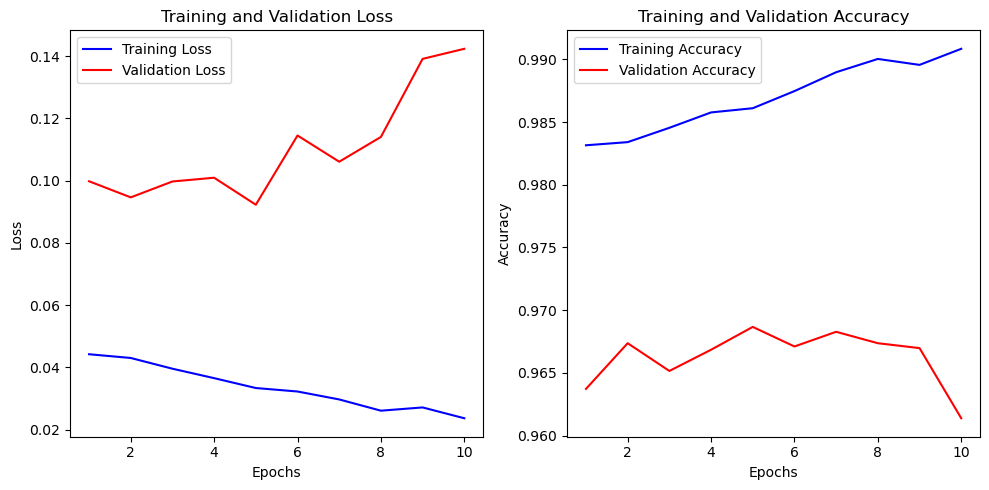

In [18]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [22]:
# 2nd best model
best_model_2 = tuner.get_best_models(num_models=2)[1]

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)
    
# Train the model with the best hyperparameters
history_of_model_2 = best_model_2.fit(X_train, 
               y_train,
               epochs=100, 
               validation_data=(X_val, y_val), 
               batch_size=32,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/100
1122/1122 [==============================] - 1283s 1s/step - loss: 0.0480 - accuracy: 0.9819 - val_loss: 0.0831 - val_accuracy: 0.9718 - lr: 5.0000e-04
Epoch 2/100
1122/1122 [==============================] - 1190s 1s/step - loss: 0.0441 - accuracy: 0.9832 - val_loss: 0.0896 - val_accuracy: 0.9704 - lr: 5.0000e-04
Epoch 3/100
1122/1122 [==============================] - 1196s 1s/step - loss: 0.0422 - accuracy: 0.9840 - val_loss: 0.0903 - val_accuracy: 0.9685 - lr: 5.0000e-04
Epoch 4/100
1122/1122 [==============================] - 1192s 1s/step - loss: 0.0420 - accuracy: 0.9835 - val_loss: 0.0933 - val_accuracy: 0.9702 - lr: 5.0000e-04
Epoch 5/100
1122/1122 [==============================] - 1192s 1s/step - loss: 0.0408 - accuracy: 0.9845 - val_loss: 0.0907 - val_accuracy: 0.9707 - lr: 5.0000e-04
Epoch 6/100
1122/1122 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9855
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1122/

In [23]:
best_model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [24]:
# Save the model architecture and weights
save_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DrowsinessDetectionOnCombinedDataset/saved_data/models/'

best_model_2.save(save_dir + 'drowsiness_detection_hpt_best_model_2.h5')

In [25]:
# Save the history object to a file
with open(save_dir + 'drowsiness_detection_hpt_best_model_2_history.pkl', 'wb') as file:
    pickle.dump(history_of_model_2.history, file)

In [26]:
training_loss = history_of_model_2.history['loss']
validation_loss = history_of_model_2.history['val_loss']

training_accuracy = history_of_model_2.history['accuracy']
validation_accuracy = history_of_model_2.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

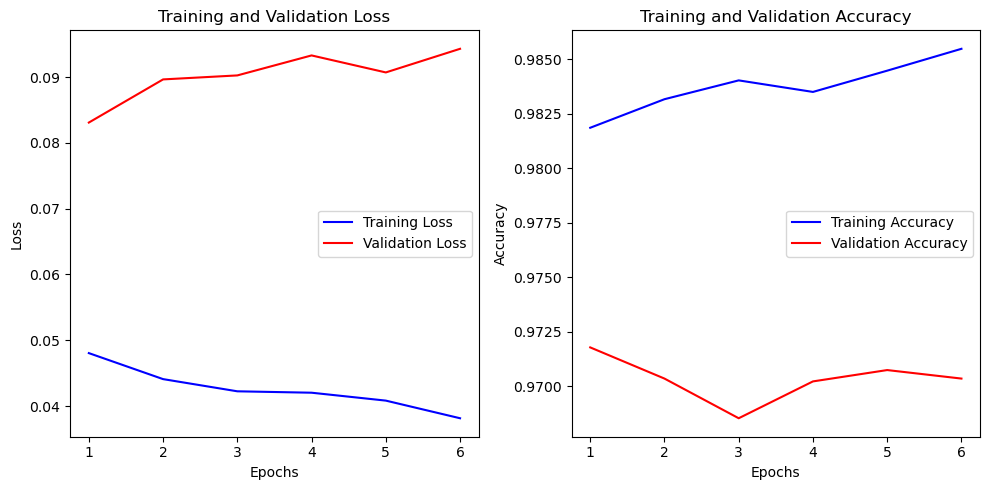

In [27]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

when comparing above best models from hyperparameter tuning 2nd model performs better - validation accuracy high and validation loss lower